In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [2]:
gt_train_coord = pickle.load( open( "./import_dataset/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "./import_dataset/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "./import_dataset/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "./import_dataset/train/inputs_train.pkl", "rb" ) )

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()
gt_train_coord.shape,gt_train.shape,in_train_coord.shape,inputs_train.shape

((11, 5157, 2),
 torch.Size([5157, 11, 4]),
 (10, 5157, 2),
 torch.Size([5157, 10, 272]))

## VALIDATION SET

In [3]:
gt_validation_coord = pickle.load( open( "./import_dataset/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "./import_dataset/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "./import_dataset/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "./import_dataset/validation/inputs_validation.pkl", "rb" ) )

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

## TEST SET

In [4]:
gt_test_coord_1 = pickle.load( open( "./import_dataset/test/gt_test_coord_1.pkl", "rb" ) )
gt_test_1 = pickle.load( open( "./import_dataset/test/gt_test_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "./import_dataset/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "./import_dataset/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "./import_dataset/test/gt_test_coord_2.pkl", "rb" ) )
gt_test_2 = pickle.load( open( "./import_dataset/test/gt_test_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "./import_dataset/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "./import_dataset/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "./import_dataset/test/gt_test_coord_3.pkl", "rb" ) )
gt_test_3 = pickle.load( open( "./import_dataset/test/gt_test_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "./import_dataset/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "./import_dataset/test/inputs_test_3.pkl", "rb" ) )

inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()

inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()

inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()

### Model

In [5]:
from torch import optim

inp_size = np.int(inputs_train.shape[2]/4)
lr = 0.01
lstm = LSTM(4*inp_size,4,num_layers=2,hidden_size=128)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

In [6]:
traindataset = utils.TensorDataset(inputs_train, gt_train[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

epochs = 50
steps = 0
print_every = 323
running_loss = 0 #### DOD

loss_train = []
loss_val = []
for e in range(epochs):
    start = time.time()
    total_train_loss=0
    steps_bis = 0
    if (e+1)%10==0:
        lr /= 5
        optimizer = optim.SGD(lstm.parameters(), lr=lr)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        steps_bis+=1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)    
        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4
        #pdb.set_trace()
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        #loss4 = 5*criterion(out[0,:,2:], targets[0,:,2:])
                                #+ 10*criterion(out_bis[-1,:,:], targets[-1,:,0:2]) 
                                #+ 10*criterion(out_bis[0,:,:], targets[0,:,0:2]))
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        #loss4.backward()
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3).item()
        total_train_loss += (loss1+loss2+loss3).item()
    
        if steps % print_every == 0:
                stop = time.time()
                val_loss=0
                for ii, (valcoord, valgt) in enumerate(valloader):
                    inputs = Variable(valcoord, volatile=True)
                    predicted = lstm.predict(inputs)
                    val_loss+= criterion(predicted,valgt).data[0]
                    
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation loss: {:.4f}..".format(val_loss/ii),
                  "Training loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
                loss_val.append(val_loss/ii)
                running_loss = 0
                start = time.time()
    loss_train.append(total_train_loss/steps_bis)

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/50.. Validation loss: 0.9903.. Training loss: 7.6537.. 0.0846 s/batch
Epoch: 2/50.. Validation loss: 0.7784.. Training loss: 3.3884.. 0.0773 s/batch
Epoch: 3/50.. Validation loss: 0.7188.. Training loss: 2.7851.. 0.0865 s/batch
Epoch: 4/50.. Validation loss: 0.7081.. Training loss: 2.6041.. 0.0777 s/batch
Epoch: 5/50.. Validation loss: 0.6780.. Training loss: 2.4974.. 0.0910 s/batch
Epoch: 6/50.. Validation loss: 0.6693.. Training loss: 2.3867.. 0.0810 s/batch
Epoch: 7/50.. Validation loss: 0.6436.. Training loss: 2.2705.. 0.0682 s/batch
Epoch: 8/50.. Validation loss: 0.6483.. Training loss: 2.1657.. 0.0661 s/batch
Epoch: 9/50.. Validation loss: 0.6662.. Training loss: 2.0183.. 0.0593 s/batch
Epoch: 10/50.. Validation loss: 0.5674.. Training loss: 1.8197.. 0.1493 s/batch
Epoch: 11/50.. Validation loss: 0.5621.. Training loss: 1.7723.. 0.2208 s/batch
Epoch: 12/50.. Validation loss: 0.5571.. Training loss: 1.7261.. 0.0936 s/batch
Epoch: 13/50.. Validation loss: 0.5417.. Training

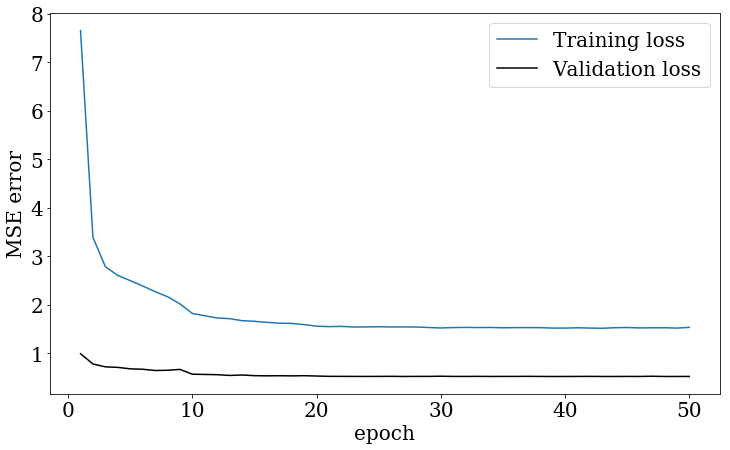

In [7]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()

In [8]:
output_test_1 = lstm.predict(inputs_test_1)
output_test_1 = output_test_1.data.numpy()

In [9]:
output_test_2 = lstm.predict(inputs_test_2)
output_test_2 = output_test_2.data.numpy()

In [10]:
output_test_3 = lstm.predict(inputs_test_3)
output_test_3 = output_test_3.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

##### Type 1 trajectory

In [11]:
output_coord_1=np.zeros([11,inputs_test_1.shape[1],2])
for j in range(11):
    for i in range(inputs_test_1.shape[1]):
        if j==0:
            output_coord_1[j,i,0:2] = in_test_coord_1[9,i,0:2]
        else:
            output_coord_1[j,i,0:2] = output_coord_1[j-1,i,0:2]+output_test_1[j-1,i,2:]*0.4
        

In [12]:
dist = np.zeros(inputs_test_1.shape[1])
for i in range(inputs_test_1.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_1[10,i,:]-output_coord_1[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 1.14


In [13]:
avr = np.zeros((inputs_test_1.shape[1],11))
for i in range(inputs_test_1.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_1[j,i,:]-output_coord_1[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.586


(-0.21352605785855316,
 0.015790017993264436,
 -0.05971125905506039,
 1.253936440156268)

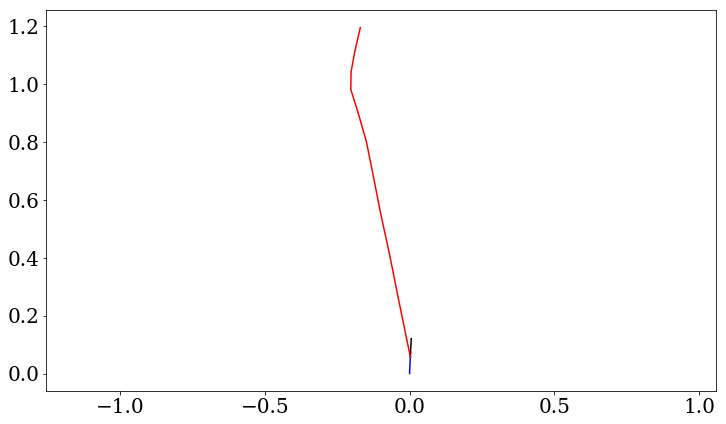

In [14]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_1.shape[1])

plt.plot(in_test_coord_1[:,ind,0],in_test_coord_1[:,ind,1],c='b')
plt.plot(gt_test_coord_1[:,ind,0],gt_test_coord_1[:,ind,1],c='k')
plt.plot(output_coord_1[:,ind,0],output_coord_1[:,ind,1],c='r')
plt.axis('equal')

##### Type 2 trajectory

In [15]:
output_coord_2=np.zeros([11,inputs_test_2.shape[1],2])
for j in range(11):
    for i in range(inputs_test_2.shape[1]):
        if j==0:
            output_coord_2[j,i,0:2] = in_test_coord_2[9,i,0:2]
        else:
            output_coord_2[j,i,0:2] = output_coord_2[j-1,i,0:2]+output_test_2[j-1,i,2:]*0.4
        

In [16]:
dist = np.zeros(inputs_test_2.shape[1])
for i in range(inputs_test_2.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_2[10,i,:]-output_coord_2[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground truth and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 1.231


In [17]:
avr = np.zeros((inputs_test_2.shape[1],11))
for i in range(inputs_test_2.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_2[j,i,:]-output_coord_2[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground truth and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.688


(-0.142527176, 2.993070696, -0.3195976309772263, 6.711550250521752)

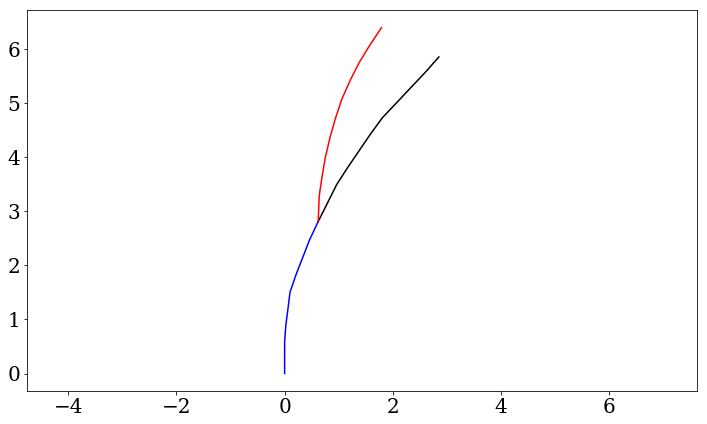

In [18]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_2.shape[1])

plt.plot(in_test_coord_2[:,ind,0],in_test_coord_2[:,ind,1],c='b')
plt.plot(gt_test_coord_2[:,ind,0],gt_test_coord_2[:,ind,1],c='k')
plt.plot(output_coord_2[:,ind,0],output_coord_2[:,ind,1],c='r')
plt.axis('equal')

##### Type 3 trajectory

In [19]:
output_coord_3=np.zeros([11,inputs_test_3.shape[1],2])
for j in range(11):
    for i in range(inputs_test_3.shape[1]):
        if j==0:
            output_coord_3[j,i,0:2] = in_test_coord_3[9,i,0:2]
        else:
            output_coord_3[j,i,0:2] = output_coord_3[j-1,i,0:2]+output_test_3[j-1,i,2:]*0.4
        

In [20]:
dist = np.zeros(inputs_test_3.shape[1])
for i in range(inputs_test_3.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_3[10,i,:]-output_coord_3[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground truth and the predicted coordinates is :',final_coord_error.round(3))


The final distance between the ground trought and the predicted coordinates is : 1.562


In [21]:
avr = np.zeros((inputs_test_3.shape[1],11))
for i in range(inputs_test_3.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_3[j,i,:]-output_coord_3[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.76


(-0.155002587, 0.716994847, -0.37174242072847746, 7.806590835298026)

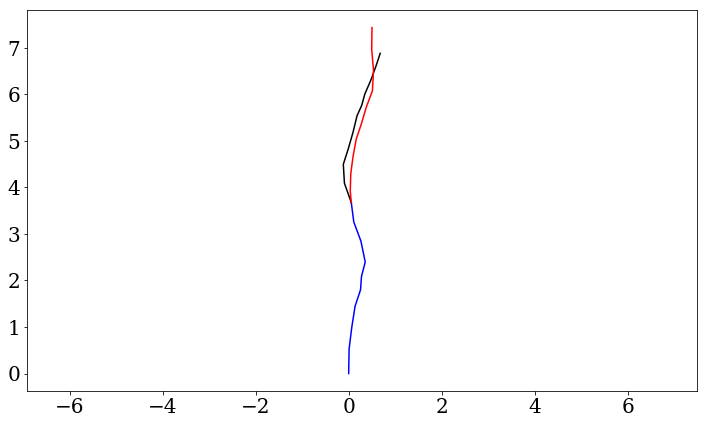

In [23]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_3.shape[1])

plt.plot(in_test_coord_3[:,ind,0],in_test_coord_3[:,ind,1],c='b')
plt.plot(gt_test_coord_3[:,ind,0],gt_test_coord_3[:,ind,1],c='k')
plt.plot(output_coord_3[:,ind,0],output_coord_3[:,ind,1],c='r')
plt.axis('equal')